In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("../camp_scripts") # change accordingly
sns.set_context('notebook')

In [4]:
from june.demography.geography import Geography
from june.demography.demography import load_age_and_sex_generators_for_bins, Demography, Population
from june.paths import data_path
from camps.paths import camp_data_path
from june import World
from june.groups import Hospital, Hospitals
from june.distributors import HospitalDistributor
from june.world import generate_world_from_hdf5
from camp_creation import generate_empty_world, populate_world, distribute_people_to_households # this is loaded from the ../camp_scripts folder

No --data argument given - defaulting to:
/home/arnau/code/CPModelling/data
No --configs argument given - defaulting to:
/home/arnau/code/CPModelling/configs


2020-06-11 15:07:11,089 - camps.paths - WARNING - No --data argument given - defaulting to:
/home/arnau/code/CPModelling/data
2020-06-11 15:07:11,090 - camps.paths - WARNING - No --configs argument given - defaulting to:
/home/arnau/code/CPModelling/configs
2020-06-11 15:07:11,091 - camps.paths - WARNING - No --camp_data argument given - defaulting to:
/home/arnau/code/CPModelling/camp_data
2020-06-11 15:07:11,092 - camps.paths - WARNING - No --configs_camps argument given - defaulting to:
/home/arnau/code/CPModelling/configs_camps


In [5]:
from camps.groups import PumpLatrines, PumpLatrineDistributor
from camps.groups import DistributionCenters, DistributionCenterDistributor
from camps.groups import Communals, CommunalDistributor
from camps.groups import FemaleCommunals, FemaleCommunalDistributor

## Initialize the world

In [6]:
# create empty world's geography
world = generate_empty_world(filter_key = {"region" : ["CXB-219"]})

2020-06-11 15:07:11,278 - june.demography.geography - INFO - There are 65 areas and 4 super_areas in the world.


In [7]:
# populate empty world
populate_world(world)

In [8]:
# distribute people to households
distribute_people_to_households(world)

In [9]:
hospitals= Hospitals.from_file(
    filename=camp_data_path / 'input/hospitals/hospitals.csv'
)
world.hospitals = hospitals
hospital_distributor = HospitalDistributor(hospitals, 
                                           medic_min_age=20,
                                           patients_per_medic=10)
hospital_distributor.distribute_medics_from_world(world.people)


2020-06-11 15:07:12,178 - june.groups.hospital - INFO - There are 8 hospitals in the world.


In [10]:
world.pumplatrines = PumpLatrines.for_areas(world.areas)
world.distribution_centers = DistributionCenters.for_areas(world.areas)
world.communals = Communals.for_areas(world.areas)
world.female_communals = FemaleCommunals.for_areas(world.areas)

## Geography exploration

### UNHCR camp blocks inside the World

In [11]:
super_areas = []
for super_area in world.super_areas:
    super_areas.append(super_area.name)

In [12]:
super_areas[:5]

['CXB-219-A', 'CXB-219-B', 'CXB-219-C', 'CXB-219-D']

### Mahjee blocks inside World

In [13]:
areas = []
for area in world.areas:
    areas.append(area.name)

In [14]:
areas[:5]

['CXB-219-062', 'CXB-219-063', 'CXB-219-061', 'CXB-219-060', 'CXB-219-065']

## Demography exploration

### UNHCR block residents

In [15]:
sample_ages = []
sample_sexes = []
for person in world.super_areas.members[0].people:
    sample_ages.append(person.age)
    sample_sexes.append(person.sex)

In [16]:
sample_sexes[:5], sample_ages[:5]

(['f', 'f', 'm', 'm', 'f'], [49, 37, 52, 20, 50])

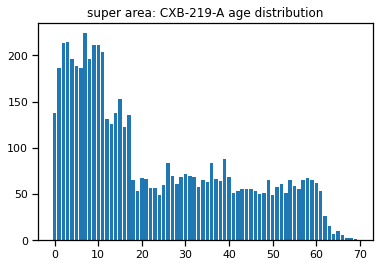

In [17]:
ages, counts = np.unique(sample_ages, return_counts=True)
plt.bar(ages, counts)
plt.title('super area: {} age distribution'.format(world.super_areas.members[0].name))
plt.show()

In [18]:
print ('The % children between ages 0-16 is {}%'.format(round(np.sum(counts[:16])/(np.sum(counts[:16])+np.sum(counts[16:]))*100)))

The % children between ages 0-16 is 49.0%


## Households

### Household size distribution

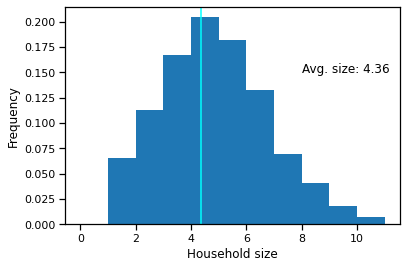

In [19]:
household_sizes = [household.size for household in world.households]
plt.hist(household_sizes, density=True, bins=np.arange(0,12))
plt.xlabel("Household size")
plt.ylabel("Frequency")
plt.axvline(np.mean(household_sizes), color="cyan")
plt.text(8, 0.150, f"Avg. size: {(np.mean(household_sizes)):.2f}")
plt.show()

## Activity exploration

### Pumps and latrines 

In [20]:
pumps_and_latrines = []
for pump_latrine in world.areas.members[0].pumplatrines:
    pumps_and_latrines.append(pump_latrine)

In [21]:
print ('There are {} pumps and latrines in area {}'.format(len(pumps_and_latrines), world.areas.members[0].name))

There are 3 pumps and latrines in area CXB-219-062


### Distribution centers

In [22]:
distribution_centers = []
for center in world.distribution_centers:
    distribution_centers.append(center)

In [23]:
distribution_centers[0].coordinates

array([21.1962 , 92.14936])

### Communal spaces

In [24]:
communal_spaces = []
for space in world.communals:
    communal_spaces.append(space)

In [25]:
communal_spaces[0].coordinates

array([21.19621, 92.14924])

### Female friendly communal spaces

In [26]:
female_communal_spaces = []
for space in world.female_communals:
    female_communal_spaces.append(space)

In [27]:
female_communal_spaces[0].coordinates

array([21.19588, 92.152  ])